In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import requests
import time

In [12]:
#load csv data into dataframe, and combine date + time columns
working_df = pd.read_csv("cleaned_car_accidents.csv" , parse_dates=[["Date" , "Time"]])
#print first 5 rows to check dataframe worked
working_df.head()

,Date_Time,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,...,Vehicle_Reference_y,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,2005-01-01 20:23:00,200520D002602,-1.832342,52.534986,2,1,3,7,300,5,...,1,1,1,1,-1,-1,3,0,9,1
1,2005-02-01 18:45:00,200520D002703,-1.846293,52.465961,3,2,2,1,300,5,...,2,1,1,1,31,6,3,0,9,1
2,2005-03-01 17:04:00,200520D004203,-1.794089,52.455003,3,1,1,2,300,3,...,1,1,1,1,24,5,3,0,9,1
3,2005-05-01 15:05:00,200520D004603,-1.869954,52.478755,1,1,2,4,300,6,...,1,1,3,1,31,6,1,0,0,1
4,2005-05-01 22:00:00,200520D006503,-1.857470,52.469211,3,2,1,4,300,6,...,2,1,1,2,22,5,3,0,9,1


# Assessment of Casualty Numbers versus Time of Day

# Question: When are accidents most likely to occur, based on time of day?

### Here, we have filtered the data by combining accidents that have occurred during specific times of day into intervals, such that we can better assess when accidents are most likely to occur.

    A 24 hour time format is being used. The intervals we have decided are as follows:
    
    Morning - 06:00 - 11:59
    Afternoon - 12:00 - 17:59
    Evening- 18:00-23:59
    Night- 00:00 - 05:59

In [13]:
#check column names for use throughout analysis
working_df.columns

Index(['Date_Time', 'Accident_Index', 'Longitude', 'Latitude',
       'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Day_of_Week', 'Local_Authority_(District)', '1st_Road_Class',
       '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail',
       'Junction_Control', '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Vehicle_Reference_x', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Journey_Purpose_of_Driver', 'Sex_of_Driver',
       'Age_of_Driver', 'Age_B

In [14]:
# Convert 'Date_Time' column to datetime objects
working_df['Date_Time'] = pd.to_datetime(working_df['Date_Time'])

# Define the bins , label the bins and add the bins to dataframe
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
working_df['Time Bin'] = pd.cut(working_df['Date_Time'].dt.hour, bins=bins, labels=labels, right=False)

In [15]:
#Total number of accidents per bin
bar_df = working_df['Time Bin'].value_counts()
bar_df

Afternoon    29780
Evening      17658
Morning      16964
Night         3909
Name: Time Bin, dtype: int64

### The below pie chart shows that majority of accidents over the time period assessed, in the West Midlands, occur during afternoon hours of 12:00 - 17:59. Common knowledge tells us that this is usually the time of day when road users use their vehicles for school runs, and the evening commute home after work. Although we cannot infer whether these accidents are occurring specifically during the school run or the commute home, we can definitely recommend that further care should be taken when driving during these hours.

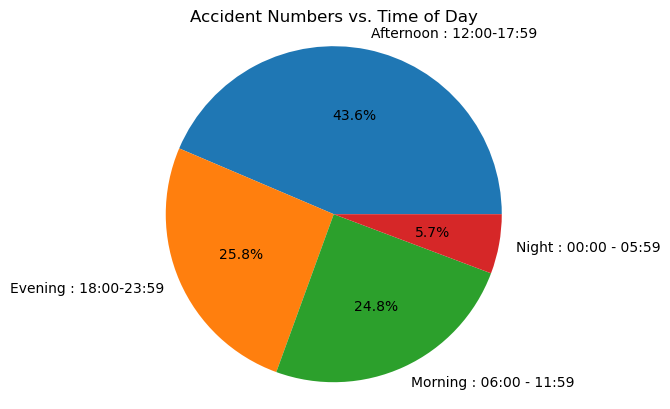

<Figure size 640x480 with 0 Axes>

In [16]:
#show relationship between time of day and number of accidents
labels = ['Afternoon : 12:00-17:59' , 'Evening : 18:00-23:59' , 'Morning : 06:00 - 11:59', 'Night : 00:00 - 05:59']
plt.pie(bar_df,labels=labels,autopct="%1.1f%%")
plt.title('Accident Numbers vs. Time of Day')
plt.axis("equal")
plt.show()

#save as png file
plt.savefig("visualisation/jo_pie_chart.png")

# Assessment of Casualty Severity based on Light Conditions

## Question: What type of light conditions contribute to the severity of casualties?

In the government data file, the road safety key has defined values in column **'Light_Conditions'** with the below keys-

    1 : Daylight
    4 : Darkness - lights lit
    5 : Darkness - lights unlit
    6 : Darkness - no lighting
    7 : Darkness - lighting unknown
    -1 : Data missing or out of range
 
It has also defined defined values in column **'Casualty_Severity'** with the below keys--

    1 : Fatal
    2 : Serious
    3 : Slight
    
We are going to combine the data under key 5 and 6, as both involve the roads being unlit. We will be dropping the data points from key 7 and -1 as this could potentially skew or create bias in our data because we do not know if the roads were lit or not.


In [17]:
#replace keys 5 or 6 with 5-6 combined
working_df['Light_Conditions'] = working_df['Light_Conditions'].replace({5: '5-6 Combined', 6: '5-6 Combined'})
#drop 7 and -1 key values
working_df = working_df[(working_df['Light_Conditions'] != 7) & (working_df['Light_Conditions'] != -1)]
working_df['Light_Conditions'].value_counts()

1               49196
4               18193
5-6 Combined      545
Name: Light_Conditions, dtype: int64

1               294
4               227
5-6 Combined     21
Name: Light_Conditions, dtype: int64
1               5265
4               2401
5-6 Combined      77
Name: Light_Conditions, dtype: int64
1               43637
4               15565
5-6 Combined      447
Name: Light_Conditions, dtype: int64


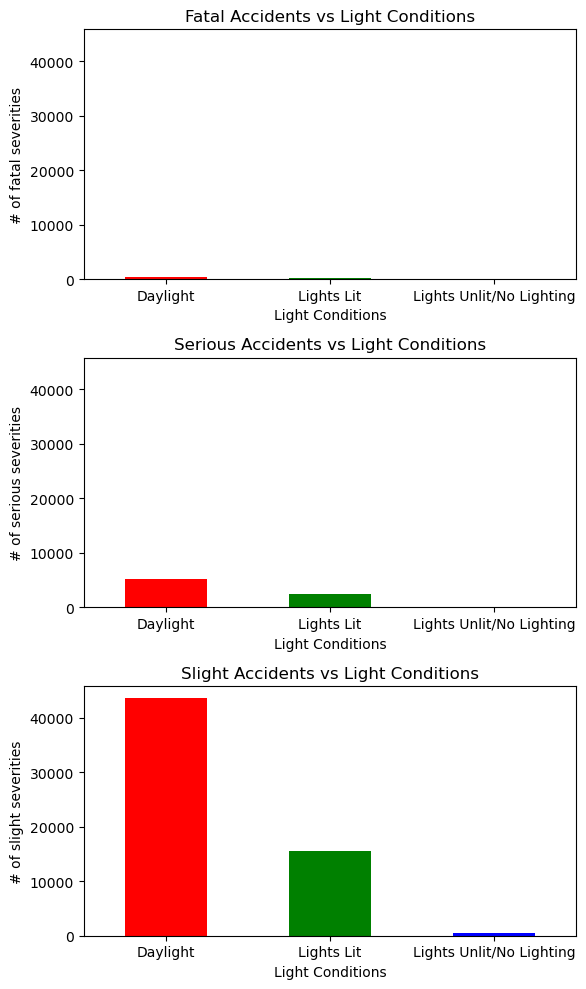

<Figure size 640x480 with 0 Axes>

In [18]:
# Define custom x-axis ticks
tick_names = ["Daylight", "Lights Lit", "Lights Unlit/No Lighting"]

# Create subplots
fig, axs = plt.subplots(3, figsize=(6, 10),sharey=True)

# For severity = fatal
working_df_fatal = working_df.loc[working_df["Casualty_Severity"] == 1]
working_fatal_light = working_df_fatal["Light_Conditions"].value_counts()
print(working_fatal_light)

#fatal vs light conditions plot
plot_1 = working_fatal_light.plot.bar(ax=axs[0],color=['red', 'green', 'blue'])
axs[0].set(xlabel="Light Conditions", ylabel="# of fatal severities", title = 'Fatal Accidents vs Light Conditions')

# Set custom x-axis ticks
axs[0].set_xticks(range(len(tick_names)))
axs[0].set_xticklabels(tick_names, rotation=0)

# For severity = serious
working_df_serious = working_df.loc[working_df["Casualty_Severity"] == 2]
working_serious_light = working_df_serious["Light_Conditions"].value_counts()
print(working_serious_light)

#serious vs light conditions plot
plot_2 = working_serious_light.plot.bar(ax=axs[1],color=['red', 'green', 'blue'])
axs[1].set(xlabel="Light Conditions", ylabel="# of serious severities", title = 'Serious Accidents vs Light Conditions')

# Set custom x-axis ticks
axs[1].set_xticks(range(len(tick_names)))
axs[1].set_xticklabels(tick_names, rotation=0)

# For severity = slight
working_df_slight = working_df.loc[working_df["Casualty_Severity"] == 3]
working_slight_light = working_df_slight["Light_Conditions"].value_counts()
print(working_slight_light)

#slight vs light conditions plot
plot_3 = working_slight_light.plot.bar(ax=axs[2],color=['red', 'green', 'blue'])
axs[2].set(xlabel="Light Conditions", ylabel="# of slight severities", title = 'Slight Accidents vs Light Conditions')

# Set custom x-axis ticks
axs[2].set_xticks(range(len(tick_names)))
axs[2].set_xticklabels(tick_names, rotation=0)

# Customize the overall plot
plt.tight_layout()

# Show the subplots
plt.show()

#Save the subplot
plt.savefig("visualisation/jo_sub_plot.png")

## Further investigation of fatalities, as difficult to compare in subplot above due to y-axis limits

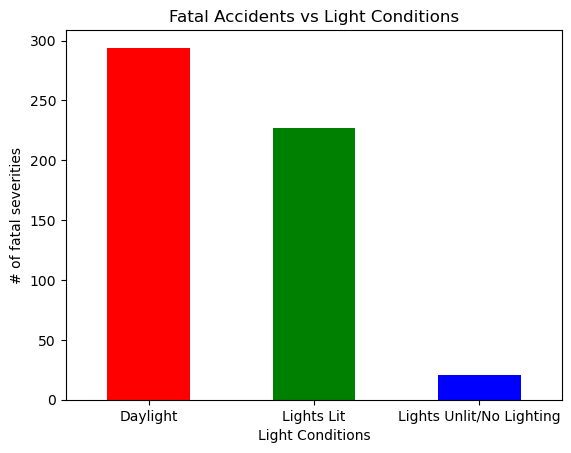

<Figure size 640x480 with 0 Axes>

In [21]:
tick_names = ["Daylight", "Lights Lit", "Lights Unlit/No Lighting"]

#fatal vs light conditions plot
plot_4 = working_fatal_light.plot.bar(working_fatal_light,color=['red', 'green', 'blue'])
plot_4.set(xlabel="Light Conditions", ylabel="# of fatal severities", title = 'Fatal Accidents vs Light Conditions')
plot_4.set_xticks(range(len(tick_names)))
plot_4.set_xticklabels(tick_names, rotation=0)

plt.show()
#Save the plot
plt.savefig("visualisation/jo_bar_plot.png")

# Can journey reasons explain the above information?

## Question: why are most accidents happening in the daylight, then?

### From the above bar plots, one can clearly see that accidents are happening when the roads are lit with daylight. This seems strange so we thought we would investigate this further. We wanted to see what the journey purpose was, as if most people are having accidents in the daylight hours, we would expect them to be doing school runs, work commutes etc.

The government data key shows the following, for values in column **'Journey_Purpose_of_Driver'**:

	1 : Journey as part of work vehicles
	2 : Commuting to/from work vehicles
	3 : Taking pupil to/from school vehicles
	4 : Pupil riding to/from school vehicles
	5 : Other vehicles
	6 : Not known vehicles
	15 : Other/Not known (2005-10) vehicles
    -1 : Data missing or out of range vehicles

In [ ]:
#Find out how many journey purposes there are and their counts

journey_purpose = working_df.groupby(working_df['Journey_Purpose_of_Driver']).size()
print(journey_purpose)

#Start pie plotting
plt.figure(figsize=(6, 6))

# Map the current labels to the government labels
label_mapping = {
    1: 'Journey as part of work vehicles',
    2: 'Commuting to/from work vehicles',
    3: 'Taking pupil to/from school vehicles',
    4: 'Pupil riding to/from school vehicles',
    5: 'Other vehicles',
    6: 'Not known vehicles',
    15: 'Other/Not known (2005-10) vehicles',
    -1: 'Data missing or out of range vehicles'
}

# Replace the current labels with the new labels
journey_purpose.index = [label_mapping[label] for label in journey_purpose.index]
journey_plot = plt.pie(journey_purpose,autopct="%1.1f%%", startangle=140, radius=5)

#format pie plot
plt.title('Journey Purpose of Drivers')
plt.axis("equal")
plt.legend(journey_purpose.index, title="Journey Purpose", bbox_to_anchor=(1.2,1.2), loc="upper center")
plt.show()

#Save the plot
plt.savefig("visualisation/jo_journey_plot.png")